In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error as mse
from sklearn.model_selection import train_test_split

#Read data

In [19]:
housing_names = ["f" + str(i) for i in range(13)] + ["price"]
adult_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours",
    "native",
    "class"
]
housing = pd.read_excel("Real estate valuation data set.xlsx")
adult = pd.read_csv("adult.csv", names=adult_names)

In [20]:
print("housing size:",housing.shape)
print("adult size:",adult.shape)

housing size: (414, 8)
adult size: (32561, 15)


In [21]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours,native,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [23]:
housing.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


#Preprocessing

#Convert to categorical datatype

In [24]:
encoder = LabelEncoder()

for col in adult_names:
    if adult[col].dtype == "object":
        adult[col] = encoder.fit_transform(adult[col])

#Normalization

In [25]:
scaler = MinMaxScaler()
adult = scaler.fit_transform(adult)
housing = scaler.fit_transform(housing)

#Train test split

In [26]:
X_adult, y_adult = adult[:, :-1], adult[:, -1]
X_housing, y_housing = housing[:, :-1], housing[:, -1]
print(X_adult.shape, y_adult.shape)
print(X_housing.shape, y_housing.shape)

(32561, 14) (32561,)
(414, 7) (414,)


In [27]:
x_train_adult, x_test_adult, y_train_adult, y_test_adult = train_test_split(X_adult, y_adult, train_size=0.8)
x_train_housing, x_test_housing, y_train_housing, y_test_housing = train_test_split(X_housing, y_housing, train_size=0.8)

In [28]:
x_train_adult.shape, x_test_adult.shape, y_train_adult.shape, y_test_adult.shape

((26048, 14), (6513, 14), (26048,), (6513,))

#Modeling

#Model 1 - Classification - MSE loss function - adult dataset

In [29]:
ad_mse = Sequential([
    Dense(units=10, input_dim= X_adult.shape[1], activation="relu"),
    Dense(units=24,activation="relu"),
    Dense(units=16,activation="relu"),
    Dense(units=8,activation="relu"),
    Dense(units=1, activation="sigmoid")
])
ad_mse.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                150       
                                                                 
 dense_1 (Dense)             (None, 24)                264       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 959
Trainable params: 959
Non-trainable params: 0
_________________________________________________________________


In [30]:
ad_mse.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

In [31]:
history_ad_mse = ad_mse.fit(x_train_adult, y_train_adult, epochs=10, validation_split=0.2, verbose=0)

In [32]:
import matplotlib.pyplot as plt

In [33]:
def plot_history(history, metrics, model_name:str):
    fig = plt.figure(figsize=[8, 4])
    for metric in metrics:
        plt.plot(history.history[metric], label='train '+ metric)
        plt.plot(history.history['val_' + metric], label='val ' + metric)        
    plt.legend()    
    plt.xlabel('epoch')
    plt.ylabel(" ".join(metrics))
    plt.grid(visible=True)
    plt.title(model_name + " training history [" + " ".join(metrics) + "]")

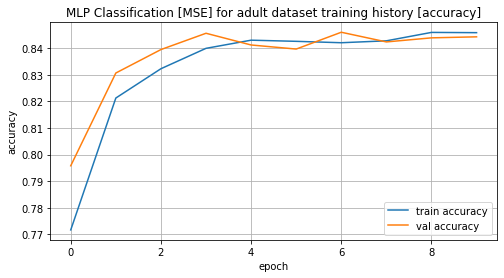

In [34]:
plot_history(history=history_ad_mse, metrics=["accuracy"],model_name="MLP Classification [MSE] for adult dataset")

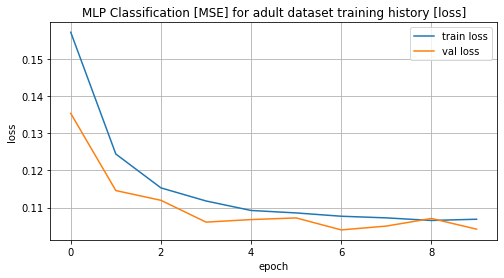

In [35]:
plot_history(history=history_ad_mse, metrics=["loss"], model_name="MLP Classification [MSE] for adult dataset")

In [36]:
# model 1
result_ad_mse = ad_mse.evaluate(x_test_adult, y_test_adult)

204/204 [==============================] - 0s 2ms/step - loss: 0.1064 - accuracy: 0.8471


#Model 2 - Classification - CCE loss function - adult dataset

In [37]:
ad_cce = Sequential([
    Dense(units=32, input_dim= X_adult.shape[1], activation="relu"),
    Dense(units=16,activation="relu"),
    Dense(units=8, activation="relu"),
    Dense(units=2, activation="softmax")
])
ad_cce.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                480       
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,162
Trainable params: 1,162
Non-trainable params: 0
_________________________________________________________________


In [38]:
ad_cce.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [39]:
history_ad_cce = ad_cce.fit(x_train_adult, y_train_adult, epochs=10, verbose=0, validation_split=0.2)

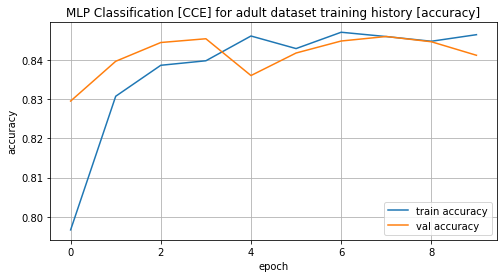

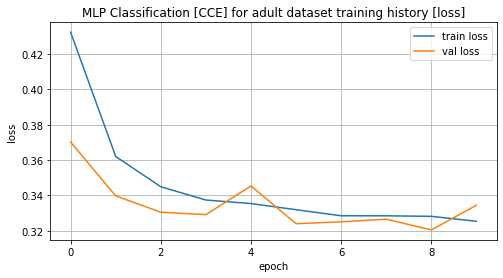

In [40]:
plot_history(history_ad_cce, metrics=["accuracy"], model_name="MLP Classification [CCE] for adult dataset")
plot_history(history_ad_cce, metrics=["loss"],model_name="MLP Classification [CCE] for adult dataset")

In [41]:

# model 2
result_ad_cce = ad_cce.evaluate(x_test_adult, y_test_adult)

204/204 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.8431


#Model 3 - Regression - MSE loss function - housing dataset

In [42]:
hs_mse = Sequential([
    Dense(units=16, input_dim= X_housing.shape[1], activation="relu"),
    Dense(units=8, activation="relu"),
    Dense(units=1)
])
hs_mse.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                128       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [43]:
hs_mse.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

In [44]:
history_hs_mse = hs_mse.fit(x_train_housing, y_train_housing, epochs=15, verbose=0, validation_split=0.2)

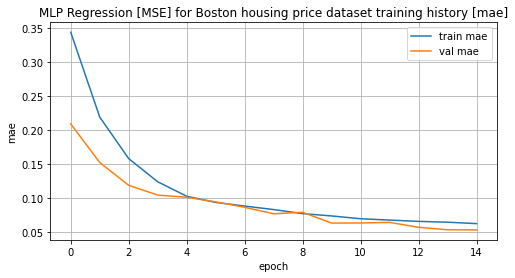

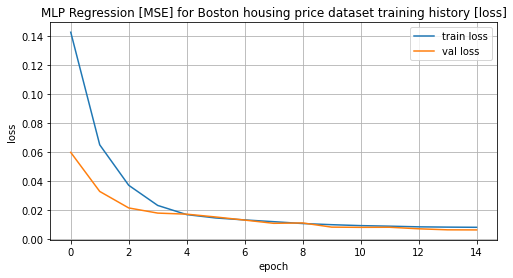

In [45]:
plot_history(history_hs_mse, metrics=["mae"], model_name="MLP Regression [MSE] for Boston housing price dataset")
plot_history(history_hs_mse, metrics=["loss"], model_name="MLP Regression [MSE] for Boston housing price dataset")

In [46]:

result_hs_mse = hs_mse.evaluate(x_test_housing, y_test_housing)

3/3 [==============================] - 0s 4ms/step - loss: 0.0072 - mae: 0.0660
